## Files and Packages

In [7]:
import scipy
import h5py
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
os.chdir('/gpfs/radev/pi/saxena/aj764/Training_COOPERATION/040124/Behavioral/')
print(os.getcwd())

/gpfs/radev/pi/saxena/aj764/Training_COOPERATION/040124/Behavioral


In [12]:
leverfile = pd.read_csv('040124_KL001B-KL001Y_lever.csv')
magfile = pd.read_csv('040124_KL001B-KL001Y_mag.csv')

In [86]:
leverfile.head()

,TrialNum,LeverNum,AbsTime,TrialCond,DispTime,TrialTime,coopTS,coopSucc,Hit,TrialEnd,AnimalID,RatID
0,1,1,0.72,3,NaN,0.70,NaN,0,1,0,KL001B-KL001Y,0
1,1,1,0.85,3,NaN,0.83,NaN,0,-1,0,KL001B-KL001Y,0
2,1,1,0.92,3,NaN,0.90,NaN,0,-1,0,KL001B-KL001Y,0
3,2,1,12.43,0,NaN,0.47,NaN,0,1,0,KL001B-KL001Y,0
4,2,1,13.62,0,NaN,1.66,NaN,0,-1,0,KL001B-KL001Y,0


In [94]:
magfile.tail()

,TrialNum,MagNum,AbsTime,Duration,TrialCond,DispTime,TrialTime,Hit,TrialEnd
135,145,2.0,3534.44,0.01,3.0,2599.75,934.69,-1.0,0.0
136,145,2.0,3754.94,0.00,3.0,2599.75,1155.19,-1.0,0.0
137,145,1.0,4327.59,0.00,3.0,2599.75,1727.84,-1.0,0.0
138,145,1.0,4789.02,0.00,3.0,2599.75,2189.27,-1.0,0.0
139,145,1.0,4789.30,0.00,3.0,2599.75,2189.55,-1.0,0.0


In [13]:
filename = ('/gpfs/radev/pi/saxena/aj764/Training_COOPERATION/040124/Tracking/h5/040124_COOPTRAIN_LARGEARENA_KL001B-KL001Y_Camera1.predictions.h5')

In [14]:
with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
/gpfs/radev/pi/saxena/aj764/Training_COOPERATION/040124/Tracking/h5/040124_COOPTRAIN_LARGEARENA_KL001B-KL001Y_Camera1.predictions.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(152761, 5, 2, 2)

===nodes===
0: nose
1: earL
2: earR
3: headBase
4: tailBase



In [19]:
NOSE_INDEX = 0
HB_INDEX = 3

nose_loc = locations[:, NOSE_INDEX, :, :]
hb_loc = locations[:, HB_INDEX, :, :]

In [105]:
nose_loc[18503]

array([[1276.46179199, 1286.41625977],
       [ 444.40014648,  218.36117554]])

## Filling in Missing Values

In [108]:
norm = locations.reshape((locations.shape[0], -1))
print(norm.shape[-1])
y = norm[:,1]
x = np.flatnonzero(~np.isnan(y))

20


In [110]:
#Define a function to fill in missing values
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [111]:
locations_new = fill_missing(locations)
test = locations_new.reshape((locations_new.shape[0], -1))
print(test.shape[-1])
test_y = test[:,1]
test_x = np.flatnonzero(~np.isnan(test_y))

20


In [123]:
nose_loc_new = locations_new[:, NOSE_INDEX, :, :]
hb_loc_new = locations_new[:, HB_INDEX, :, :]
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

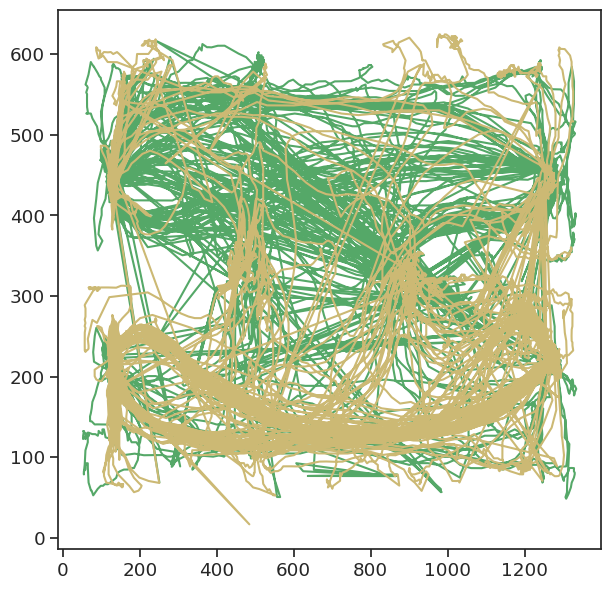

In [124]:
plt.figure(figsize=(7,7))
plt.plot(nose_loc_new[0:20000,0,0],nose_loc_new[0:20000,1,0], 'g',label='hb')
plt.plot(nose_loc_new[0:20000,0,1],nose_loc_new[0:20000,1,1], 'y',label='hb')

Text(0.5, 1.0, 'Nose locations')

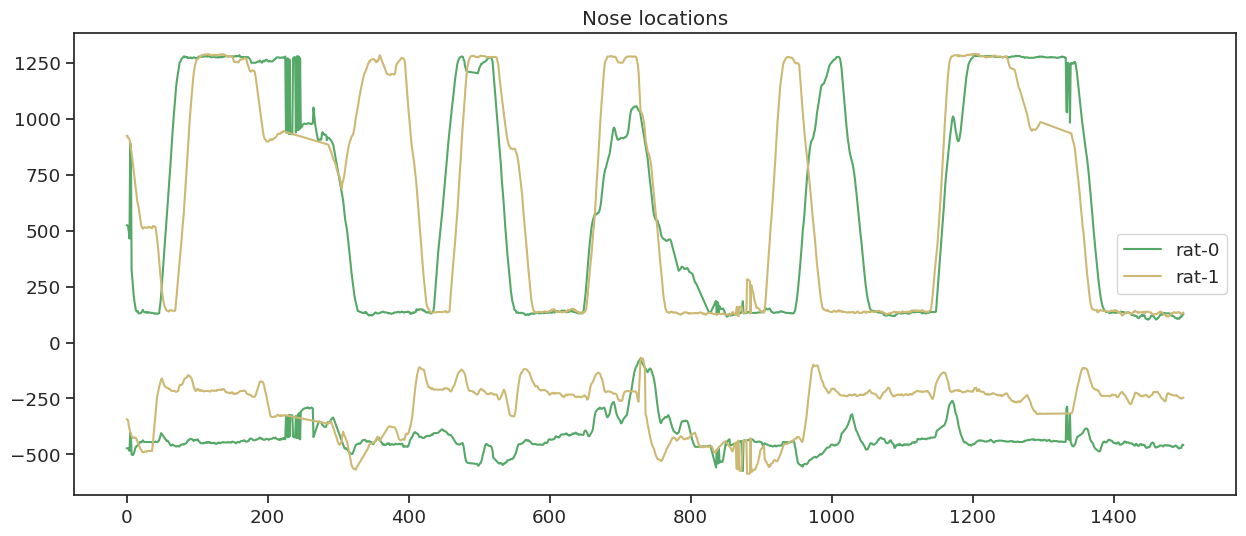

In [126]:
plt.figure()
plt.plot(nose_loc_new[0:1500,0,0], 'g',label='rat-0')
plt.plot(nose_loc_new[0:1500,0,1], 'y',label='rat-1')

plt.plot(-1*nose_loc_new[0:1500,1,0], 'g')
plt.plot(-1*nose_loc_new[0:1500,1,1], 'y')

plt.legend(loc="center right")
plt.title('Nose locations')

## Parameters and Functions

In [69]:
fps = 30

In [79]:
levx = 135
loc2y = 200
loc1y = 440
magx = 1260

In [80]:
ratID = []

for row in leverfile.itertuples(index=False):
    # Calculate the frame for every lever press
    frame = int(row.AbsTime * fps)

    # Get coordinates of both mice for the said frame
    ratpos1 = nose_loc[frame, :, 0]
    ratpos2 = nose_loc[frame, :, 1]
    
    # Calculate the distances for LeverNum 1 and 2
    if row.LeverNum == 1:
        distance1 = np.sqrt((ratpos1[0] - levx)**2 + (ratpos1[1] - loc1y)**2)
        distance2 = np.sqrt((ratpos2[0] - levx)**2 + (ratpos2[1] - loc1y)**2)

    elif row.LeverNum == 2:
        distance1 = np.sqrt((ratpos1[0] - levx)**2 + (ratpos1[1] - loc2y)**2)
        distance2 = np.sqrt((ratpos2[0] - levx)**2 + (ratpos2[1] - loc2y)**2)
    else:
        continue  # Skip if LeverNum is not 1 or 2

    # Assign the action to one of the mice
    ratNum = 0 if distance1 < distance2 else 1

    # Add new element to the list
    ratID.append(ratNum)

# Add new column to the dataframe
leverfile["RatID"] = ratID

In [92]:
magfile.AbsTime = np.nan_to_num(magfile.AbsTime, nan=0)

In [104]:
ratID = []

for row in magfile.itertuples(index=False):
    # Calculate the frame for every lever press
    frame = int(row.AbsTime * fps)

    # Get coordinates of both mice for the said frame
    ratpos1 = nose_loc[frame, :, 0]
    ratpos2 = nose_loc[frame, :, 1]
    
    # Calculate the distances for LeverNum 1 and 2
    if row.MagNum == 1:
        distance1 = np.sqrt((ratpos1[0] - magx)**2 + (ratpos1[1] - loc1y)**2)
        distance2 = np.sqrt((ratpos2[0] - magx)**2 + (ratpos2[1] - loc1y)**2)

    elif row.MagNum == 2:
        distance1 = np.sqrt((ratpos1[0] - magx)**2 + (ratpos1[1] - loc2y)**2)
        distance2 = np.sqrt((ratpos2[0] - magx)**2 + (ratpos2[1] - loc2y)**2)

    else:
        ratNum = 100 #assign number for Nan values
        ratID.append(ratNum)
        continue  # Skip if LeverNum is not 1 or 2

    # Assign the action to one of the mice
    ratNum = 0 if distance1 < distance2 else 1

    # Add new element to the list
    ratID.append(ratNum)

# Add new column to the dataframe
magfile["RatID"] = ratID